In [ ]:
# Main
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

# Outliers
from scipy import stats

# Encoding
from sklearn.preprocessing import LabelEncoder

# For the Model
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import lightgbm as lgb
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LinearRegression as SklearnLinearRegression
from sklearn.linear_model import Ridge as SklearnRidge
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, mean_squared_error, r2_score
from catboost import CatBoostClassifier

# If needed
import itertools
from itertools import combinations
import math

import warnings
warnings.filterwarnings("ignore")

# Dataframe
df = pd.read_csv("./data/heart_2022_with_nans.csv")

# df.head()

# Encoding

df_numeric = df.copy()

# Encode the target variable (HadHeartAttack: Yes/No to 1/0)
df_numeric['HadHeartAttack'] = df_numeric['HadHeartAttack'].map({'No': 0, 'Yes': 1})

# Define ordinal mappings for ordinal columns
ordinal_mappings = {
    'GeneralHealth': {'Poor': 0, 'Fair': 1, 'Good': 2, 'Very good': 3, 'Excellent': 4},
    'AgeCategory': {
        'Age 18 to 24': 0, 'Age 25 to 29': 1, 'Age 30 to 34': 2, 'Age 35 to 39': 3,
        'Age 40 to 44': 4, 'Age 45 to 49': 5, 'Age 50 to 54': 6, 'Age 55 to 59': 7,
        'Age 60 to 64': 8, 'Age 65 to 69': 9, 'Age 70 to 74': 10, 'Age 75 to 79': 11,
        'Age 80 or older': 12
    }
}

# Apply ordinal encoding
for col, mapping in ordinal_mappings.items():
    df_numeric[col] = df_numeric[col].map(mapping)

# Encode nominal categorical columns with LabelEncoder
nominal_cols = [
    'State', 'Sex', 'LastCheckupTime', 'PhysicalActivities', 'RemovedTeeth',
    'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD',
    'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes',
    'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 'DifficultyConcentrating',
    'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands',
    'SmokerStatus', 'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory',
    'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver',
    'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos'
]

le = LabelEncoder()
for col in nominal_cols:
    df_numeric[col] = le.fit_transform(df_numeric[col].astype(str))

# Check for Duplicates

non_useful_cols = [
    'State', 'HeightInMeters', 'WeightInKilograms', 'TetanusLast10Tdap',
    'CovidPos', 'ECigaretteUsage', 'HighRiskLastYear', 'HIVTesting',
    'FluVaxLast12', 'BlindOrVisionDifficulty', 'DifficultyErrands', 'PneumoVaxEver'
]

df_filtered = df.drop(columns=non_useful_cols)

df_filtered.duplicated().sum()

# Handling Duplicates
df_filtered.drop_duplicates(inplace=True)
df_filtered.duplicated().sum() 
df_filtered.shape

# Check for Missing Values
df_filtered.isna().sum()
# Count missing values in each row
missing_counts = df_filtered.isna().sum(axis=1)

# Identify rows with 2 or more missing values and count them
num_rows_to_delete = (missing_counts >= 2).sum()
print(f"\nTotal number of rows with 2 or more missing values: {num_rows_to_delete}")

# Count occurrences of each missing value count
missing_distribution = missing_counts[missing_counts >= 2].value_counts().sort_index()
print("Distribution of missing values per row:")
print(missing_distribution)

# Calculate missing value percentages
missing_percentages = df_filtered.isnull().mean() * 100

# Categorize columns based on missing value percentage ranges
ranges = {
    "0-10%": [],
    "10-20%": [],
    "20-30%": [],
    "30-40%": [],
    "50-50%": [],
    "50-60%": [],
    "60-70%": [],
    "70-80%": [],
    "80-90%": [],
    "90-100%": []
}

for col, perc in missing_percentages.items():
    if 0 <= perc < 10:
        ranges["0-10%"].append(col)
    elif 10 <= perc < 20:
        ranges["10-20%"].append(col)
    elif 20 <= perc < 30:
        ranges["20-30%"].append(col)
    elif 30 <= perc < 40:
        ranges["30-40%"].append(col)
    elif 40 <= perc < 50:
        ranges["40-50%"].append(col)
    elif 50 <= perc < 60:
        ranges["50-60%"].append(col)
    elif 60 <= perc < 70:
        ranges["60-70%"].append(col)
    elif 70 <= perc < 80:
        ranges["70-80%"].append(col)
    elif 80 <= perc < 90:
        ranges["80-90%"].append(col)
    elif 90 <= perc <= 100:
        ranges["90-100%"].append(col)

# Print results
for range_label, cols in ranges.items():
    print(f"Columns with missing values in range {range_label}: {cols}")

# Handling missing values
# Remove rows with missing HadHeartAttack
df_filtered = df_filtered.dropna(subset=['HadHeartAttack'])
print("Rows after dropping missing HadHeartAttack:", df_filtered.shape[0])

# Remove rows with 10 or more missing values
missing_per_row = df_filtered.isna().sum(axis=1)
df_filtered = df_filtered[missing_per_row < 10]
print("Rows after dropping rows with 10+ missing values:", df_filtered.shape[0])

# Impute missing values
# Numeric columns: impute with median
numeric_cols = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'BMI']
df_filtered[numeric_cols] = df_filtered[numeric_cols].fillna(df_filtered[numeric_cols].median())

# Ordinal columns: impute with mode
ordinal_cols = ['GeneralHealth', 'AgeCategory']
df_filtered[ordinal_cols] = df_filtered[ordinal_cols].fillna(df_filtered[ordinal_cols].mode().iloc[0])

# Categorical columns: impute with mode
categorical_cols = [
    'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing',
    'LastCheckupTime', 'PhysicalActivities', 'RemovedTeeth', 'HadAngina', 'HadStroke',
    'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease',
    'HadArthritis', 'HadDiabetes', 'DeafOrHardOfHearing', 'SmokerStatus', 'ChestScan',
    'RaceEthnicityCategory', 'AlcoholDrinkers'
]
df_filtered[categorical_cols] = df_filtered[categorical_cols].fillna(df_filtered[categorical_cols].mode().iloc[0])

# Verify missing values are handled
print("Missing values after imputation:\n", df_filtered.isna().sum())
print("Final shape:", df_filtered.shape)


Total number of rows with 2 or more missing values: 63944
Distribution of missing values per row:
2     22907
3     12580
4      4854
5      2397
6      2436
7      1866
8     12420
9      2944
10      878
11      282
12      119
13       45
14       35
15       22
16       18
17        9
18       20
19       17
20       18
21       15
22       11
23        6
24       23
25        8
26       12
27        2
Name: count, dtype: int64
Columns with missing values in range 0-10%: ['Sex', 'GeneralHealth', 'PhysicalHealthDays', 'MentalHealthDays', 'LastCheckupTime', 'PhysicalActivities', 'SleepHours', 'RemovedTeeth', 'HadHeartAttack', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes', 'DeafOrHardOfHearing', 'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 'SmokerStatus', 'RaceEthnicityCategory', 'AgeCategory']
Columns with missing values in range 10-20%: ['ChestScan', 'BMI'

### Progress 5 : Model Evaluation

In [2]:
# step 1 - data preparation for modeling

# First, let's ensure all columns are numeric
print("Checking data types...")
non_numeric_cols = df_filtered.select_dtypes(exclude=[np.number]).columns.tolist()
print(f"\nNon-numeric columns found: {non_numeric_cols}")

# Apply encoding to any remaining non-numeric columns (excluding target)
for col in non_numeric_cols:
    if col != 'HadHeartAttack':  # Don't encode the target
        print(f"Encoding {col}...")
        le = LabelEncoder()
        df_filtered[col] = le.fit_transform(df_filtered[col].astype(str))

print("\nAll columns are now numeric:")

# Select features for modeling
# Features for regression (predicting BMI)
reg_features = [
    'AgeCategory', 'GeneralHealth', 'PhysicalHealthDays', 'MentalHealthDays', 
    'SleepHours', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 
    'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 
    'HadDiabetes', 'SmokerStatus'
]

# Features for classification (predicting HadHeartAttack)
class_features = [
    'AgeCategory', 'GeneralHealth', 'BMI', 'PhysicalHealthDays', 'MentalHealthDays', 
    'SleepHours', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 
    'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 
    'HadDiabetes', 'SmokerStatus', 'PhysicalActivities', 'AlcoholDrinkers'
]

# Targets
reg_target = 'BMI'  # For regression example
class_target = 'HadHeartAttack'  # For classification

# Check if all features exist in the dataframe
available_features = df_filtered.columns.tolist()

# Filter features to only include available ones
reg_features = [f for f in reg_features if f in available_features]
class_features = [f for f in class_features if f in available_features]

print(f"\nRegression features: {len(reg_features)} features")
print(f"Classification features: {len(class_features)} features")

Checking data types...

Non-numeric columns found: ['Sex', 'GeneralHealth', 'LastCheckupTime', 'PhysicalActivities', 'RemovedTeeth', 'HadHeartAttack', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes', 'DeafOrHardOfHearing', 'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 'SmokerStatus', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory', 'AlcoholDrinkers']
Encoding Sex...
Encoding GeneralHealth...
Encoding LastCheckupTime...
Encoding PhysicalActivities...
Encoding RemovedTeeth...
Encoding HadAngina...
Encoding HadStroke...
Encoding HadAsthma...
Encoding HadSkinCancer...
Encoding HadCOPD...
Encoding HadDepressiveDisorder...
Encoding HadKidneyDisease...
Encoding HadArthritis...
Encoding HadDiabetes...
Encoding DeafOrHardOfHearing...
Encoding DifficultyConcentrating...
Encoding DifficultyWalking...
Encoding DifficultyDressingBathing...
Encoding SmokerStatus...
Encodin

In [3]:
# step 2 - model evaluation functions

def evaluate_regression_model(model, X_train, y_train, X_test, y_test, model_name):
    """Evaluate regression model performance"""
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"  Training MSE: {train_mse:.4f}, R²: {train_r2:.4f}")
    print(f"  Testing MSE:  {test_mse:.4f}, R²:  {test_r2:.4f}")
    
    return {
        'model': model,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'y_test_pred': y_test_pred
    }

def evaluate_classification_model(model, X_train, y_train, X_test, y_test, model_name):
    """Evaluate classification model performance"""
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"  Training Accuracy: {train_acc:.4f}")
    print(f"  Testing Accuracy:  {test_acc:.4f}")
    
    # Print classification report
    print(f"\n  Classification Report:")
    print(classification_report(y_test, y_test_pred, target_names=['No Heart Disease', 'Heart Disease']))
    
    return {
        'model': model,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'y_test_pred': y_test_pred
    }

In [4]:
# step 3 - data splitting and scaling

# Prepare data for regression (predicting BMI)
X_reg = df_filtered[reg_features]
y_reg = df_filtered[reg_target]

# Prepare data for classification (predicting HadHeartAttack)
X_class = df_filtered[class_features]
y_class = df_filtered[class_target]

print(f"Regression data shape: X={X_reg.shape}, y={y_reg.shape}")
print(f"Classification data shape: X={X_class.shape}, y={y_class.shape}")

# Split data FIRST, then convert
# Split regression data (using pandas DataFrames)
X_train_reg_df, X_test_reg_df, y_train_reg_df, y_test_reg_df = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# Split classification data
X_train_class_df, X_test_class_df, y_train_class_df, y_test_class_df = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42, stratify=y_class
)

print(f"\nRegression data:")
print(f"  Training: {X_train_reg_df.shape[0]} samples, {X_train_reg_df.shape[1]} features")
print(f"  Testing:  {X_test_reg_df.shape[0]} samples, {X_test_reg_df.shape[1]} features")

print(f"\nClassification data:")
print(f"  Training: {X_train_class_df.shape[0]} samples, {X_train_class_df.shape[1]} features")
print(f"  Testing:  {X_test_class_df.shape[0]} samples, {X_test_class_df.shape[1]} features")
print(f"  Class distribution (training):")
print(f"    No Heart Disease: {(y_train_class_df == 0).sum()} ({(y_train_class_df == 0).mean():.1%})")
print(f"    Heart Disease:    {(y_train_class_df == 1).sum()} ({(y_train_class_df == 1).mean():.1%})")

# Now convert to numpy arrays and scale
# For regression
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg_df)
X_test_reg_scaled = scaler_reg.transform(X_test_reg_df)
y_train_reg = y_train_reg_df.values
y_test_reg = y_test_reg_df.values

# For classification
scaler_class = StandardScaler()
X_train_class_scaled = scaler_class.fit_transform(X_train_class_df)
X_test_class_scaled = scaler_class.transform(X_test_class_df)
y_train_class = y_train_class_df.values
y_test_class = y_test_class_df.values

print("\nFeatures successfully scaled using StandardScaler")
print(f"Scaled regression features shape: {X_train_reg_scaled.shape}")
print(f"Scaled classification features shape: {X_train_class_scaled.shape}")

Regression data shape: X=(436448, 15), y=(436448,)
Classification data shape: X=(436448, 18), y=(436448,)

Regression data:
  Training: 349158 samples, 15 features
  Testing:  87290 samples, 15 features

Classification data:
  Training: 349158 samples, 18 features
  Testing:  87290 samples, 18 features
  Class distribution (training):
    No Heart Disease: 0 (0.0%)
    Heart Disease:    0 (0.0%)

Features successfully scaled using StandardScaler
Scaled regression features shape: (349158, 15)
Scaled classification features shape: (349158, 18)


In [5]:
# step 4 - model evaluation

print("\n--- LINEAR REGRESSION (Predicting BMI) ---")
# Use SklearnLinearRegression (renamed import to avoid conflict)
lr_results = evaluate_regression_model(
    SklearnLinearRegression(),  # Changed from LinearRegression()
    X_train_reg_scaled, y_train_reg,
    X_test_reg_scaled, y_test_reg,
    "Linear Regression"
)

print("\n--- RANDOM FOREST CLASSIFIER (Predicting Heart Disease) ---")
rf_results = evaluate_classification_model(
    RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    X_train_class_scaled, y_train_class,
    X_test_class_scaled, y_test_class,
    "Random Forest Classifier"
)


--- LINEAR REGRESSION (Predicting BMI) ---

Linear Regression Performance:
  Training MSE: 36.2468, R²: 0.0661
  Testing MSE:  36.0852, R²:  0.0669

--- RANDOM FOREST CLASSIFIER (Predicting Heart Disease) ---

Random Forest Classifier Performance:
  Training Accuracy: 0.9981
  Testing Accuracy:  0.9404

  Classification Report:
                  precision    recall  f1-score   support

No Heart Disease       0.95      0.99      0.97     82288
   Heart Disease       0.45      0.17      0.24      5002

        accuracy                           0.94     87290
       macro avg       0.70      0.58      0.61     87290
    weighted avg       0.92      0.94      0.93     87290




--- LEARNING CURVES ANALYSIS ---

Linear Regression Learning Curves:


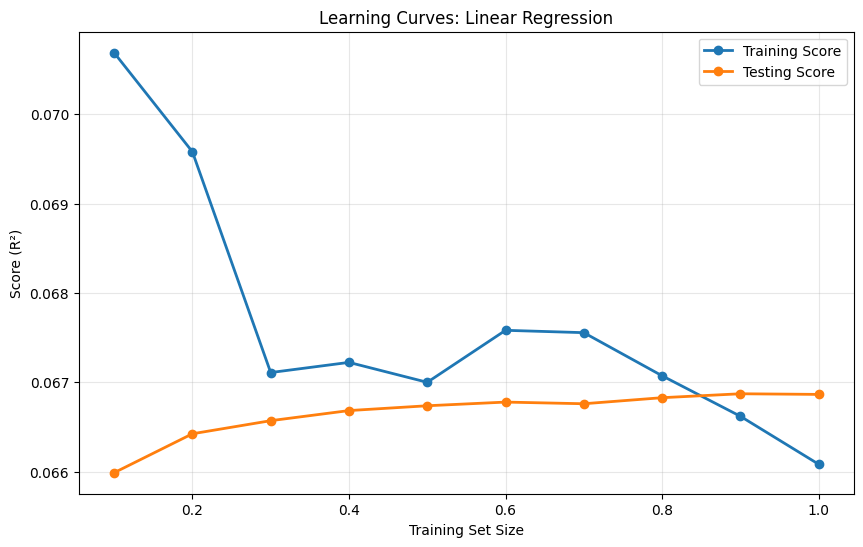


Linear Regression:
  Final Training Score: 0.0661
  Final Testing Score:  0.0669
  Gap (Training - Testing): -0.0008
  Diagnosis: ⚠️ UNDER-FITTING

Random Forest Learning Curves:


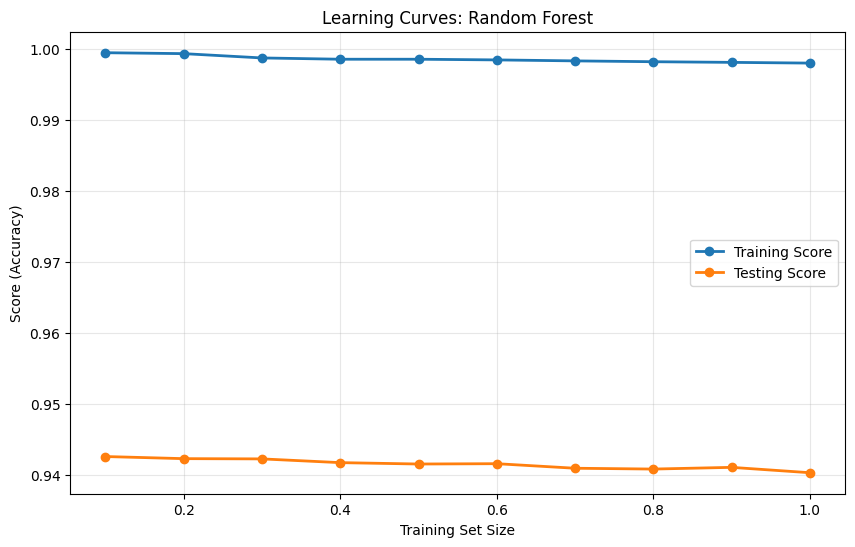


Random Forest:
  Final Training Score: 0.9981
  Final Testing Score:  0.9404
  Gap (Training - Testing): 0.0577
  Diagnosis: ✅ GOOD FIT


In [6]:
# step 5 - over-fitting & under-fitting analysis
def plot_learning_curves(model, X_train, y_train, X_test, y_test, model_name, is_classification=True):
    """Plot learning curves to diagnose over/under-fitting"""
    
    train_scores = []
    test_scores = []
    train_sizes = np.linspace(0.1, 1.0, 10)
    
    for size in train_sizes:
        # Calculate subset size
        n_samples = int(size * len(X_train))
        
        # Train on subset
        model.fit(X_train[:n_samples], y_train[:n_samples])
        
        # Calculate scores
        train_score = model.score(X_train[:n_samples], y_train[:n_samples])
        test_score = model.score(X_test, y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores, 'o-', label='Training Score', linewidth=2)
    plt.plot(train_sizes, test_scores, 'o-', label='Testing Score', linewidth=2)
    plt.xlabel('Training Set Size')
    plt.ylabel('Score (Accuracy)' if is_classification else 'Score (R²)')
    plt.title(f'Learning Curves: {model_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Diagnose
    final_gap = train_scores[-1] - test_scores[-1]
    print(f"\n{model_name}:")
    print(f"  Final Training Score: {train_scores[-1]:.4f}")
    print(f"  Final Testing Score:  {test_scores[-1]:.4f}")
    print(f"  Gap (Training - Testing): {final_gap:.4f}")
    
    if final_gap > 0.1:
        print("  Diagnosis: ⚠️ OVER-FITTING")
    elif test_scores[-1] < 0.6:
        print("  Diagnosis: ⚠️ UNDER-FITTING")
    else:
        print("  Diagnosis: ✅ GOOD FIT")

print("\n--- LEARNING CURVES ANALYSIS ---")

# Create fresh models for learning curves
lr_for_lc = SklearnLinearRegression()  # Changed from LinearRegression()
rf_for_lc = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

print("\nLinear Regression Learning Curves:")
plot_learning_curves(
    lr_for_lc,
    X_train_reg_scaled, y_train_reg,
    X_test_reg_scaled, y_test_reg,
    "Linear Regression",
    is_classification=False
)

print("\nRandom Forest Learning Curves:")
plot_learning_curves(
    rf_for_lc,
    X_train_class_scaled, y_train_class,
    X_test_class_scaled, y_test_class,
    "Random Forest",
    is_classification=True
)

In [8]:
# step 6 - ridge regression (L2 regularization)

# Try different alpha values for Ridge Regression
alphas = [0.001, 0.01, 0.1, 1, 10, 100]

ridge_results_dict = {}
for alpha in alphas:
    ridge = SklearnRidge(alpha=alpha, random_state=42)  # Changed from Ridge()
    ridge.fit(X_train_reg_scaled, y_train_reg)
    
    train_score = ridge.score(X_train_reg_scaled, y_train_reg)
    test_score = ridge.score(X_test_reg_scaled, y_test_reg)
    
    ridge_results_dict[alpha] = {
        'train_score': train_score,
        'test_score': test_score,
        'gap': train_score - test_score
    }
    
    print(f"Alpha={alpha}: Train R²={train_score:.4f}, Test R²={test_score:.4f}, Gap={train_score-test_score:.4f}")

# Find best alpha (smallest gap between train and test)
best_alpha = min(ridge_results_dict, key=lambda x: ridge_results_dict[x]['gap'])
print(f"\nBest alpha (smallest gap): {best_alpha}")

# Train final Ridge model with best alpha
ridge_final = SklearnRidge(alpha=best_alpha, random_state=42)  # Changed from Ridge()
ridge_final_results = evaluate_regression_model(
    ridge_final,
    X_train_reg_scaled, y_train_reg,
    X_test_reg_scaled, y_test_reg,
    f"Ridge Regression (alpha={best_alpha})"
)

Alpha=0.001: Train R²=0.0661, Test R²=0.0669, Gap=-0.0008
Alpha=0.01: Train R²=0.0661, Test R²=0.0669, Gap=-0.0008
Alpha=0.1: Train R²=0.0661, Test R²=0.0669, Gap=-0.0008
Alpha=1: Train R²=0.0661, Test R²=0.0669, Gap=-0.0008
Alpha=10: Train R²=0.0661, Test R²=0.0669, Gap=-0.0008
Alpha=100: Train R²=0.0661, Test R²=0.0669, Gap=-0.0008

Best alpha (smallest gap): 0.001

Ridge Regression (alpha=0.001) Performance:
  Training MSE: 36.2468, R²: 0.0661
  Testing MSE:  36.0852, R²:  0.0669
